In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import subprocess
import os

In [2]:
# import my modules for reading dataframes from folder /modules

import sys

sys.path.insert(0, 'modules/')
    
from tumor_data_processor_with_sex_chr import * 
from tumor_data_processor_2 import * 
from lengths_data_processor import *
from centromeres_data_processor import *

In [3]:
data = pd.read_csv('datasets/P6.Inform/I062.015.WGS.Tumor_events.txt', sep='\t', comment='#')

data

,Chromosome Region,Event,Length,Cytoband,% of CNV Overlap,Probe Median,% Heterozygous,Probes,Count of Gene Symbols
0,"chr1:0-648,442",CN Gain,648443,p36.33,98.457688,0.378064,NaN,13,25
1,"chr1:142,535,839-158,568,553",Allelic Imbalance,16032715,q12 - q23.1,54.242139,0.023077,100.0,10,425
2,"chr1:158,568,553-163,226,118",CN Gain,4657566,q23.1 - q23.3,36.627208,0.287899,NaN,148,112
3,"chr1:219,528,940-249,250,621",CN Gain,29721682,q41 - q44,32.777867,0.251258,NaN,902,302
4,"chr2:10,768,725-32,389,147",CN Gain,21620423,p25.1 - p22.3,24.545594,0.419571,NaN,659,180
...,...,...,...,...,...,...,...,...,...
290,"chrX:153,281,693-153,945,270",High Copy Gain,663578,q28,100.000000,0.900531,NaN,20,40
291,"chrX:153,945,270-154,722,592",CN Gain,777323,q28,100.000000,0.407783,NaN,24,47
292,"chrX:154,722,592-155,270,560",CN Loss,547969,q28,89.647206,-0.414165,NaN,15,8
293,"chrY:3,095,792-7,022,409",CN Loss,3926618,p11.2,10.072309,-0.692149,NaN,12,19


In [4]:
test_data = process_tumor_data_with_sex(data)

test_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,648443,0,648442
1,1,3,4657566,158568553,163226118
2,1,3,29721682,219528940,249250621
3,2,3,21620423,10768725,32389147
4,2,4,79538,33069397,33148934
...,...,...,...,...,...
278,X,3,663578,153281693,153945270
279,X,2,777323,153945270,154722592
280,X,0,547969,154722592,155270560
281,Y,0,3926618,3095792,7022409


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Chromosome   283 non-null    object
 1   Copy Number  283 non-null    int64 
 2   Length       283 non-null    int64 
 3   Start        283 non-null    int64 
 4   End          283 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 11.2+ KB


In [6]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [7]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [8]:
centromeres = pd.read_csv('datasets/centromeres.txt', sep='\t')

centromeres = process_centromeres_data(centromeres)

centromeres

,Chromosome,Start,End
0,1,121535434,124535434
1,2,92326171,95326171
2,3,90504854,93504854
3,4,49660117,52660117
4,5,46405641,49405641
5,6,58830166,61830166
6,7,58054331,61054331
7,8,43838887,46838887
8,9,47367679,50367679
9,X,58632012,61632012


### Initializing VCF parser

In [9]:
import vcf

vcf_reader_raw = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')
vcf_reader = vcf.Reader(filename='datasets/P6.Inform/P13.WES.Discovery.vcf.gz')

### Fill profile by segments with copy number 2

Some constants and parameters:

In [10]:
Mb = 1000000
S_small = 3 * Mb
LST_SMb = 10 * Mb
qual_threshold = 200

In [11]:
# TODO refactoring - count length in this function
def insert_row(df, _chr, cn, length, start, end, index):
    normal_segment = pd.DataFrame({
        'Chromosome': [ _chr ],
        'Copy Number': [ cn ],
        'Length': [length],
        'Start': [ start ],
        'End': [ end ]
    })
                
    return pd.concat([df.iloc[:index], normal_segment, df.iloc[index:]]).reset_index(drop=True)


def fill_segments(data, sex='male'):
    df = data.copy()
    index_df = 0

    for index, row in data.iterrows():
        # determining normal CN based on sex and chromosome
        normal_cn = 2
        if sex == 'male' and row['Chromosome'] in ['X', 'Y']:
            normal_cn = 1
        
        # first cnv region in chromosome
        if index == 0 or data.loc[index-1, 'Chromosome'] != data.loc[index, 'Chromosome']:
            if row['Start'] != 0:
                df = insert_row(df, row['Chromosome'], normal_cn, row['Start'], 0, row['Start'], index_df)
                index_df += 1

        # not first cnv region in chromosome 
        elif data.loc[index-1, 'End'] != data.loc[index, 'Start']:
            prev = data.loc[index-1]

            df = insert_row(df, row['Chromosome'], normal_cn, row['Start'] - prev['End'], prev['End'], row['Start'], index_df)
            index_df += 1

        # last cnv region in chromosome
        if index == len(data) - 1 or data.loc[index+1, 'Chromosome'] != data.loc[index, 'Chromosome']:

            chr_len = lengths.loc[row['Chromosome'], 'Length']
            if row['End'] != chr_len:      
                df = insert_row(df, row['Chromosome'], normal_cn, chr_len - row['End'], row['End'], chr_len, index_df+1)
                index_df += 1

        index_df += 1
        
    return df

In [12]:
pd.set_option('display.max_rows', 1000)

In [13]:
filled_data = fill_segments(test_data)

filled_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,648443,0,648442
1,1,2,157920111,648442,158568553
2,1,3,4657566,158568553,163226118
3,1,2,56302822,163226118,219528940
4,1,3,29721682,219528940,249250621
5,2,2,10768725,0,10768725
6,2,3,21620423,10768725,32389147
7,2,2,680250,32389147,33069397
8,2,4,79538,33069397,33148934
9,2,3,1388891,33148934,34537824


In [14]:
chromosome_names_male = [str(_chr) for _chr in range(1, 23)]
chromosome_names_male.append('X')
chromosome_names_male.append('Y')

In [15]:
# TODO refactoring - get dataframe made by segments of current chromosome and then work with it
def remove_centromeres(data):
    for _chr in chromosome_names_male:
        centromere_start = centromeres.loc[centromeres['Chromosome'] == _chr, 'Start'].iloc[0]
        centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]
        
        # drop segments that start and end in centromere  
        data = data.drop(data[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_start) & (data['End'] <= centromere_end)].index)
        
        # cut segment that overlaps centromere  
        row_df = data.loc[(data['Chromosome'] == _chr) & (data['Start'] < centromere_start) & (data['End'] > centromere_end)]
        if not row_df.empty:
            row = row_df.iloc[0]
            data.loc[row.name, 'End'] = centromere_start
            data.loc[row.name, 'Length'] = centromere_start - row['Start']        
            data = insert_row(data, _chr, row['Copy Number'], row['End'] - centromere_end, centromere_end, row['End'], row.name + 1)
        
        # cut segment that ends in centromere  
        data.loc[(data['Chromosome'] == _chr) & (data['End'] >= centromere_start) & (data['End'] <= centromere_end), 'End'] = centromere_start

        # cut segment that starts in centromere  
        data.loc[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_start) & (data['Start'] <= centromere_end), 'Start'] = centromere_end
    
    return data

In [16]:
data_without_centromeres = remove_centromeres(filled_data)

data_without_centromeres

,Chromosome,Copy Number,Length,Start,End
0,1,3,648443,0,648442
1,1,2,120886992,648442,121535434
2,1,2,34033119,124535434,158568553
3,1,3,4657566,158568553,163226118
4,1,2,56302822,163226118,219528940
5,1,3,29721682,219528940,249250621
6,2,2,10768725,0,10768725
7,2,3,21620423,10768725,32389147
8,2,2,680250,32389147,33069397
9,2,4,79538,33069397,33148934


In [17]:
def name_chr_arms(data):
    data['Arm'] = 'p'
    for _chr in chromosome_names_male:
        centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]

        data.loc[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_end), 'Arm'] = 'q'
        
    return data

In [18]:
data_with_named_arms = name_chr_arms(data_without_centromeres)

data_with_named_arms

,Chromosome,Copy Number,Length,Start,End,Arm
0,1,3,648443,0,648442,p
1,1,2,120886992,648442,121535434,p
2,1,2,34033119,124535434,158568553,q
3,1,3,4657566,158568553,163226118,q
4,1,2,56302822,163226118,219528940,q
5,1,3,29721682,219528940,249250621,q
6,2,2,10768725,0,10768725,p
7,2,3,21620423,10768725,32389147,p
8,2,2,680250,32389147,33069397,p
9,2,4,79538,33069397,33148934,p


### Counting DNA index

In [19]:
def count_dna_index(data, sex='male'):
    cns = list(data['Copy Number'])
    weights = list(data['Length'])

    for _chr in chromosome_names_male:
        chr_segments = data[data['Chromosome'] == _chr]
        if chr_segments.empty:
            normal_cn = 2
            if sex == 'male' and _chr in ['X', 'Y']:
                normal_cn = 1
            
            centromere_start = centromeres.loc[centromeres['Chromosome'] == _chr, 'Start'].iloc[0]
            centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]
            chromosome_end = lengths.loc[_chr, 'Length']

            cns.extend([normal_cn, normal_cn])
            weights.extend([centromere_start, chromosome_end - centromere_end])

    cn_avg = np.average(cns, weights=weights)
    dna_index = cn_avg / 2

    return dna_index

In [20]:
dna_index = count_dna_index(data_with_named_arms)

dna_index

1.0339647737087514

### Estimating number of chromosomes

In [21]:
def count_arm_avg_cn(arm_data):
    cns = list(arm_data['Copy Number'])
    weights = list(arm_data['Length'])
    
    return np.average(cns, weights=weights)


def estimate_chromosome_number(data, sex='male'):
    chromosome_number = 0

    for _chr in chromosome_names_male:
        chr_segments = data[data['Chromosome'] == _chr]
        
        # if there are no CNVs in whole chromosome add 2 for p and q arm to sum
        if chr_segments.empty:
            normal_cn = 2
            if sex == 'male' and _chr in ['X', 'Y']:
                normal_cn = 1
            
            chromosome_number += normal_cn + normal_cn
            continue

        # estimate chromosome number for p arm
        p_arm_data = chr_segments.loc[chr_segments['Arm'] == 'p']
        last_segment_p = p_arm_data.iloc[-1]
        if last_segment_p['Length'] >= 1.5 * Mb:
            chromosome_number += last_segment_p['Copy Number']
        else:
            chromosome_number += count_arm_avg_cn(p_arm_data)

        # estimate chromosome number for q arm
        q_arm_data = chr_segments.loc[chr_segments['Arm'] == 'q']
        first_segment_q = q_arm_data.iloc[0]
        if first_segment_q['Length'] >= 1.5 * Mb:
            chromosome_number += first_segment_q['Copy Number']
        else:
            chromosome_number += count_arm_avg_cn(q_arm_data)
                    
    return chromosome_number

In [22]:
chromosome_number = estimate_chromosome_number(data_with_named_arms)

chromosome_number

97.25053267374572

### Counting number of variants for each segment

Quality check that filters out records their characteristics don't meet requirements. If characteristics are not present, record remains.

In [23]:
def has_quality(record):
    info = record.INFO
    return record.QUAL > qual_threshold and ('QD' not in info.keys() or info['QD'] > 10.0) and ('MQ' not in info.keys() or info['MQ'] > 40.0) \
        and ('FS' not in info.keys() or info['FS'] < 30.0 ) and ('SOR' not in info.keys() or info['SOR'] < 3.0) \
        and ('MQRankSum' not in info.keys() or info['MQRankSum'] > -12.5) and ('ReadPosRankSum' not in info.keys() or info['ReadPosRankSum'] > -8.0)

In [24]:
def count_variants(data, vcf_reader, sample_index):
    filled_variants_data = data.copy()
    filled_variants_data['Variants Count per Mb'] = 0

    for index, row in filled_variants_data.iterrows():
        
        segment_records = None
        try:
            segment_records = vcf_reader.fetch(row['Chromosome'], row['Start'], row['End'])
        except ValueError:
            continue
        
        count = 0
        for record in segment_records:
            sample = record.samples[sample_index]

            if has_quality(record) and sample['GT'] != './.' and sample['GT'] != '0/0' and sample['AD'] != None and sample['AD'][1] != 0:
                count += 1

        length_mb = filled_variants_data.loc[index, 'Length'] / 1000000
        filled_variants_data.loc[index, 'Variants Count per Mb'] = count / length_mb

    return filled_variants_data

In [25]:
filled_variants_data = count_variants(data_with_named_arms, vcf_reader_raw, 3)

filled_variants_data

,Chromosome,Copy Number,Length,Start,End,Arm,Variants Count per Mb
0,1,3,648443,0,648442,p,0.000000
1,1,2,120886992,648442,121535434,p,8.263916
2,1,2,34033119,124535434,158568553,q,6.963805
3,1,3,4657566,158568553,163226118,q,17.820467
4,1,2,56302822,163226118,219528940,q,6.536084
5,1,3,29721682,219528940,249250621,q,9.824478
6,2,2,10768725,0,10768725,p,2.878707
7,2,3,21620423,10768725,32389147,p,6.475359
8,2,2,680250,32389147,33069397,p,11.760382
9,2,4,79538,33069397,33148934,p,0.000000


### Some visualizations

In [26]:
def plot_chromosomes_variant_count(data):
    fig,axs = plt.subplots(nrows=12, ncols=2, figsize=(15, 40), constrained_layout=True)
    max_count = data['Variants Count per Mb'].max()

    for index, name in enumerate(chromosome_names_male):
        chr_data = data[data['Chromosome'] == name]
        chr_data = chr_data.reset_index(drop=True)

        ax = axs[index // 2, index % 2]
        ax.set_ylim([0, max_count + 10])
        ax.set_title('Variant counts - chromosome ' + name, fontdict={'fontsize': 16})
        ax.bar(chr_data.index, chr_data['Variants Count per Mb'])

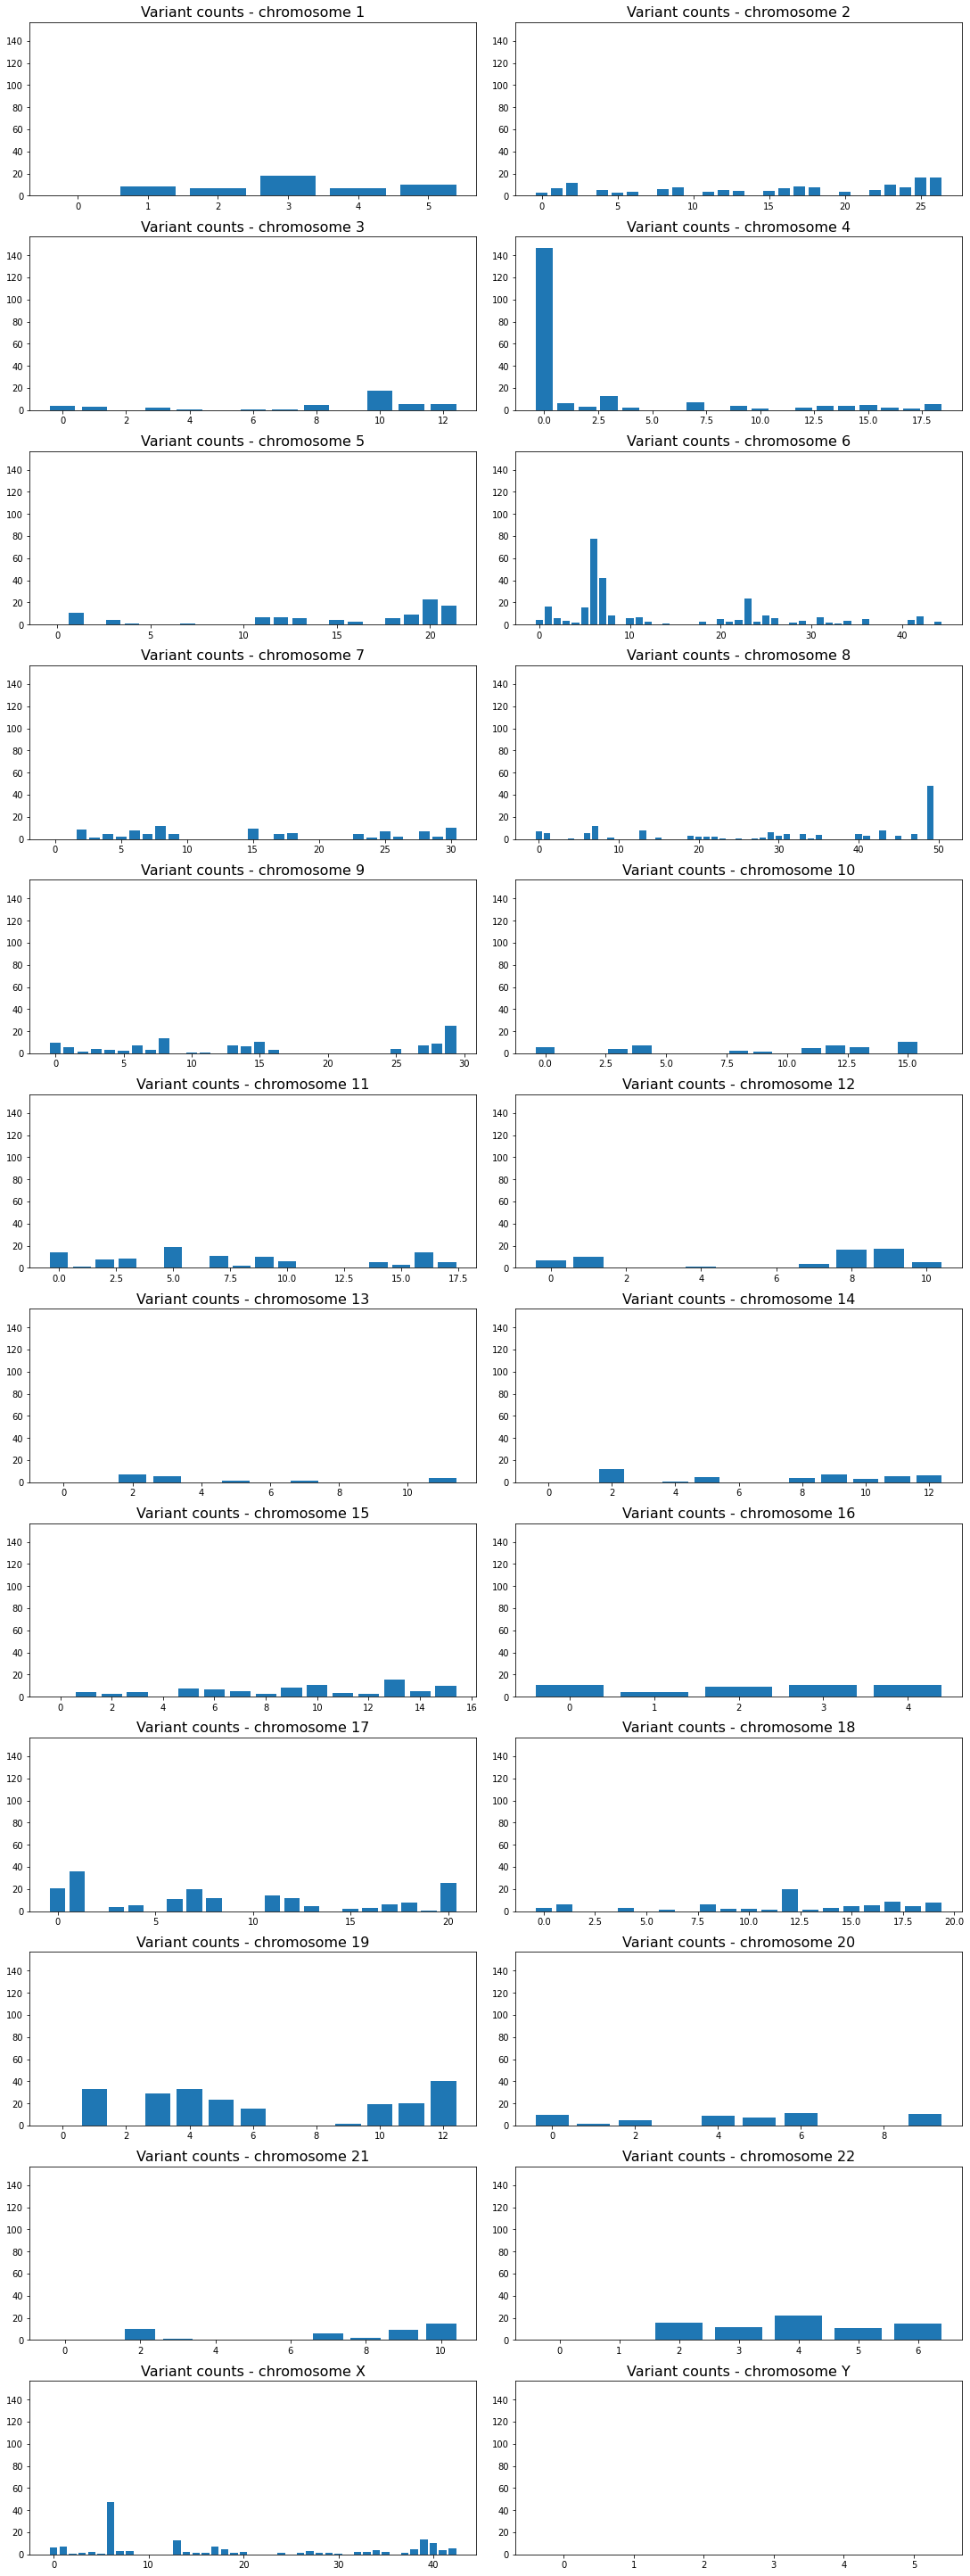

In [27]:
plot_chromosomes_variant_count(filled_variants_data)

In [28]:
def plot_genome_variant_counts(data):
    max_count = data['Variants Count per Mb'].max()
    yticks = [i for i in range(0, int(max_count) + 10, 5)]

    plt.figure(figsize=(20, 10))
    plt.yticks(ticks=yticks)
    plt.title('Variant counts', fontdict={'fontsize': 16})
    plt.bar(data.index, data['Variants Count per Mb'])

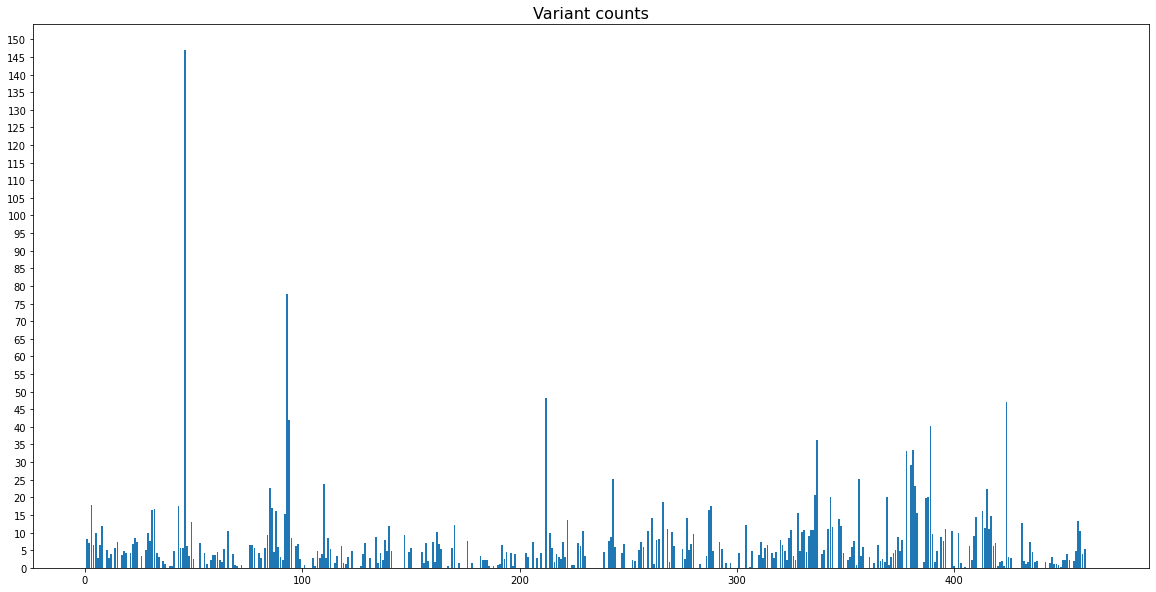

In [29]:
plot_genome_variant_counts(filled_variants_data)

### Segments sorted by number of variants

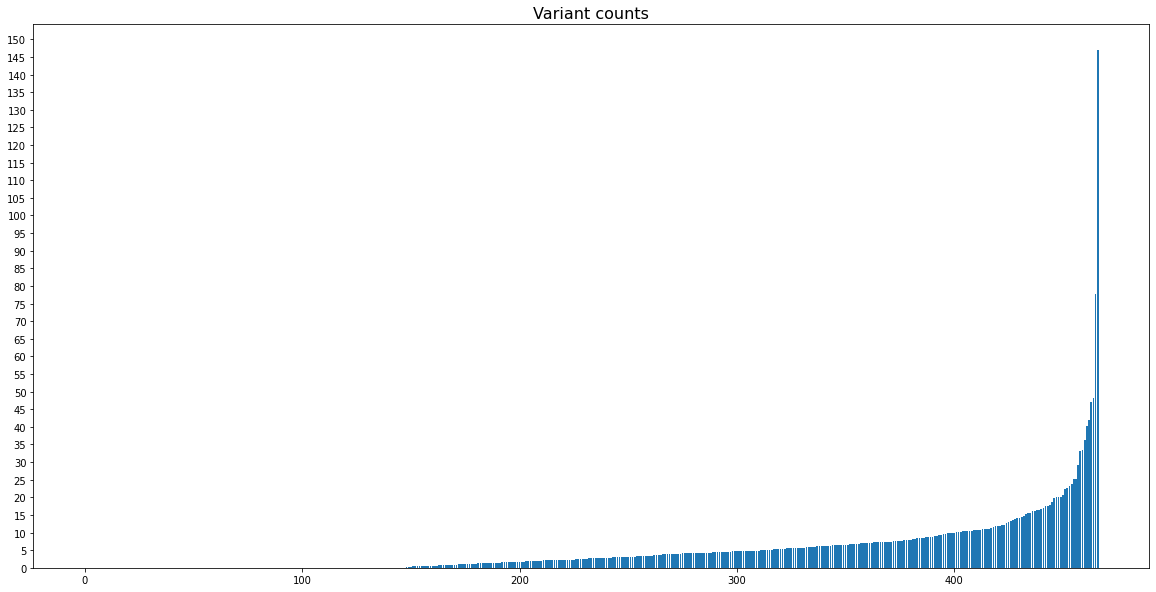

In [30]:
sorted_filled_variants_data = filled_variants_data.sort_values(by=['Variants Count per Mb']).reset_index()

plot_genome_variant_counts(sorted_filled_variants_data)

In [31]:
def plot_histogram(data):
    max_value = data['Variants Count per Mb'].max()
    xticks = [i for i in range(0, int(max_value) + 10, 4)]
    plt.figure(figsize=(20,10))
    plt.hist(data['Variants Count per Mb'], bins=int(data['Variants Count per Mb'].max()) // 2)
    plt.title('Histogram of variants count values', fontdict={'fontsize': 16})
    plt.xticks(ticks=xticks)

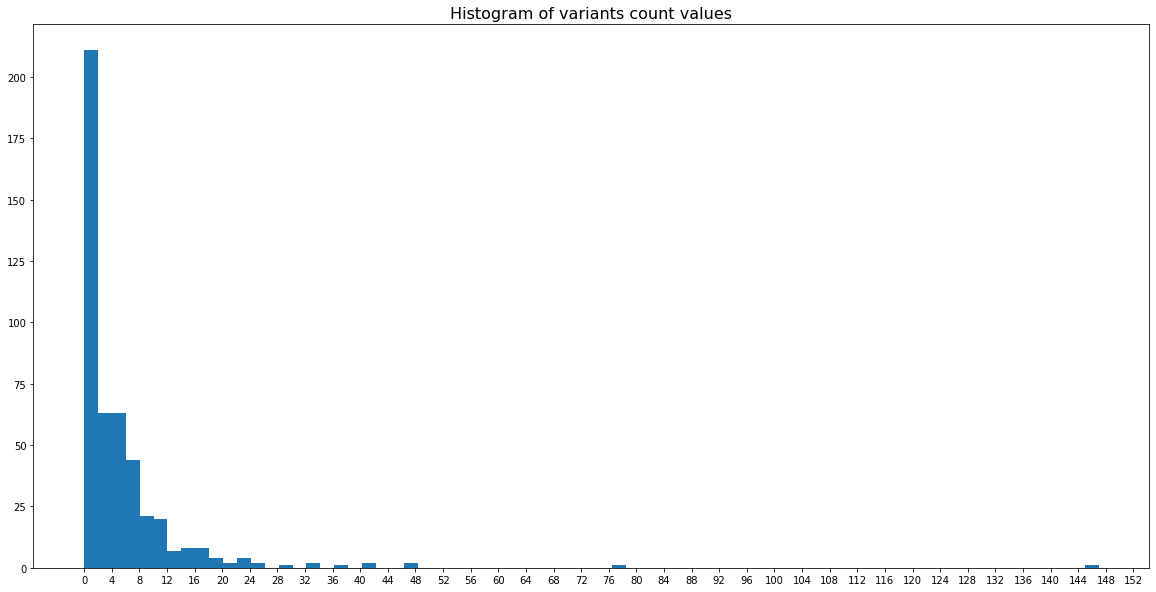

In [32]:
plot_histogram(filled_variants_data)

### Counting allele frequencies for each segment

In [33]:
def count_allele_freqs(data, vcf_reader, sample_index):
    data_with_af = data.copy()
    data_with_af['Allele Frequencies'] = [list() for x in range(len(data_with_af.index))]

    for index, row in data_with_af.iterrows():

        segment_records = None
        try:
            segment_records = vcf_reader.fetch(row['Chromosome'], row['Start'], row['End'])
        except ValueError:
            continue
            
        allele_freqs = []
        for record in segment_records:
            sample = record.samples[sample_index]

            if has_quality(record) and sample['GT'] != './.' and sample['GT'] != '0/0' and sample['AD'] != './.' and sample['AD'] != None and sample['AD'][1] != 0:
               
                allele_freq = sample['AD'][1] / (sample['AD'][0] + sample['AD'][1])
                allele_freqs.append(allele_freq)

        data_with_af.at[index, 'Allele Frequencies'] = allele_freqs
        
    return data_with_af

In [34]:
data_with_af = count_allele_freqs(data_with_named_arms, vcf_reader_raw, 3)

data_with_af

,Chromosome,Copy Number,Length,Start,End,Arm,Allele Frequencies
0,1,3,648443,0,648442,p,[]
1,1,2,120886992,648442,121535434,p,"[1.0, 0.5490196078431373, 1.0, 1.0, 1.0, 1.0, ..."
2,1,2,34033119,124535434,158568553,q,"[0.5902777777777778, 0.4097222222222222, 0.443..."
3,1,3,4657566,158568553,163226118,q,"[0.5503597122302158, 0.5813953488372093, 0.416..."
4,1,2,56302822,163226118,219528940,q,"[0.5845070422535211, 0.35691318327974275, 0.74..."
5,1,3,29721682,219528940,249250621,q,"[0.41509433962264153, 0.997289972899729, 1.0, ..."
6,2,2,10768725,0,10768725,p,"[0.8709677419354839, 1.0, 1.0, 1.0, 1.0, 0.836..."
7,2,3,21620423,10768725,32389147,p,"[0.355, 0.43828715365239296, 0.376744186046511..."
8,2,2,680250,32389147,33069397,p,"[1.0, 0.9948979591836735, 0.996969696969697, 1..."
9,2,4,79538,33069397,33148934,p,[]


### Coercing and counting of LSTs based on copy numbers and allelic frequencies

In [35]:
# insert new segment that was created by linking 
def insert_row_with_af(df, _chr, cn, length, start, end, allele_freqs, arm, index):
    normal_segment = pd.DataFrame({
        'Chromosome': [ _chr ],
        'Copy Number': [ cn ],
        'Length': [length],
        'Start': [ start ],
        'End': [ end ],
        'Allele Frequencies': [allele_freqs],
        'Arm': [arm]
    })
                
    return pd.concat([df.iloc[:index], normal_segment, df.iloc[index:]]).reset_index(drop=True)


# linking adjacent segments of small filtered out segment 
def link_segments(df, prev, _next, small):
    df = df.drop(index=prev.name)
    df = df.drop(index=_next.name)
    
    new_allele_freqs = []
    new_allele_freqs.extend(prev['Allele Frequencies'])
    new_allele_freqs.extend(_next['Allele Frequencies'])
    new_allele_freqs.extend(small['Allele Frequencies'])
    
    df = insert_row_with_af(df, prev['Chromosome'], prev['Copy Number'],  _next['End'] - prev['Start'],  prev['Start'], _next['End'], new_allele_freqs, \
                            prev['Arm'], prev.name)
    
    return df


# statistical tests for equality of allelic frequencies for two segments
def have_equal_allele_freqs(segment1, segment2):
    alpha = 0.05
    min_n = 3
    
    allele_freqs1 = segment1['Allele Frequencies']
    allele_freqs2 = segment2['Allele Frequencies']
    
    # check if there is sufficient number of observations, if no, segments are compared only by copy number
    if len(allele_freqs1) < min_n and len(allele_freqs2) < min_n:
        return True
    
    if len(allele_freqs1) < min_n or len(allele_freqs2) < min_n:
        return False
    
    statistic, p_value = stats.ttest_ind(allele_freqs1, allele_freqs2, equal_var=False)
    
    if p_value > alpha:
        return True
    
    return False


# coercing function
def coercing(data):
    df = data.copy()

    while True:

        # get smallest segment
        row = df[df['Length'] == df['Length'].min()].iloc[0]
        index = row.name

        # filter out?
        if row['Length'] < S_small:

            # not first or last segment of profile?
            if index != 0 and index != len(df) - 1:
                prev = df.loc[ index-1 ]
                _next = df.loc[ index+1 ]

                # can link?
                if prev['Chromosome'] == _next['Chromosome'] and prev['Arm'] == _next['Arm'] and prev['Copy Number'] == _next['Copy Number'] \
                    and have_equal_allele_freqs(prev, _next):
                    
                    df = link_segments(df, prev, _next, row)

            # delete small segment
            df = df.drop(index=index).reset_index(drop=True)

        # if there are no small segments left -> end
        else:
            return df

In [36]:
coerced_data_with_af = coercing(data_with_af)

coerced_data_with_af

,Chromosome,Copy Number,Length,Start,End,Arm,Allele Frequencies
0,1,2,120886992,648442,121535434,p,"[1.0, 0.5490196078431373, 1.0, 1.0, 1.0, 1.0, ..."
1,1,2,34033119,124535434,158568553,q,"[0.5902777777777778, 0.4097222222222222, 0.443..."
2,1,3,4657566,158568553,163226118,q,"[0.5503597122302158, 0.5813953488372093, 0.416..."
3,1,2,56302822,163226118,219528940,q,"[0.5845070422535211, 0.35691318327974275, 0.74..."
4,1,3,29721682,219528940,249250621,q,"[0.41509433962264153, 0.997289972899729, 1.0, ..."
5,2,2,10768725,0,10768725,p,"[0.8709677419354839, 1.0, 1.0, 1.0, 1.0, 0.836..."
6,2,3,23769099,10768725,34537824,p,"[0.355, 0.43828715365239296, 0.376744186046511..."
7,2,2,57788347,34537824,92326171,p,"[0.48, 1.0, 0.44715447154471544, 0.43373493975..."
8,2,2,61545390,97539595,159084985,q,"[0.49333333333333335, 0.5526315789473685, 1.0,..."
9,2,2,38640088,159560769,198200857,q,"[1.0, 0.4357976653696498, 0.46226415094339623,..."


Counting number of LSTs.

In [37]:
def count_lsts(data, LST_SMb=10*Mb):
    
    lsts = 0
    for index, row in data.iterrows():

        # not last segment in profile?
        if index != len(data) - 1:

            _next = data.loc[index+1]
            if row['Length'] >= LST_SMb and _next['Length'] >= LST_SMb and _next['Chromosome'] == row['Chromosome'] and _next['Arm'] == row['Arm'] \
                and _next['Start'] - row['End'] < S_small:
                
                lsts += 1

    return lsts

In [38]:
lsts_with_af = count_lsts(coerced_data_with_af)

lsts_with_af

31

In [39]:
Mb = 1000000
S_small = 3 * Mb
LST_SMbs = [x for x in range(3, 12)]
qual_threshold = 200

chromosome_names_male = [str(_chr) for _chr in range(1, 23)]
chromosome_names_male.append('X')
chromosome_names_male.append('Y')

def lst(data, vcf_reader, sample_index):
    data = fill_segments(data)
    data = remove_centromeres(data)
    data = name_chr_arms(data)
    dna_index = count_dna_index(data)
    chromosome_number = estimate_chromosome_number(data)
    data = count_allele_freqs(data, vcf_reader, sample_index)
    data = coercing(data)
    lsts = {}
    for LST_SMb in LST_SMbs:
        lsts[str(LST_SMb)+' Mb'] = count_lsts(data, LST_SMb*Mb)
    
    return lsts, dna_index, chromosome_number

In [40]:
lsts, dna_index, chromosome_number = lst(test_data, vcf_reader_raw, 3)

lsts, dna_index, chromosome_number

({'3 Mb': 83,
  '4 Mb': 65,
  '5 Mb': 52,
  '6 Mb': 46,
  '7 Mb': 43,
  '8 Mb': 37,
  '9 Mb': 33,
  '10 Mb': 31,
  '11 Mb': 28},
 1.0339647737087514,
 97.25053267374572)

In [41]:
dirpath = 'datasets/P6.Inform'

samples = [
    {
        'Filename': 'I062.007.WGS.Pre_events.txt',
        'vcf_index': 1
    },
    {
        'Filename': 'I062.007.WGS.Tumor_events.txt',
        'vcf_index': 2
    },
    {
        'Filename': 'I062.015.WGS.Tumor_events.txt',
        'vcf_index': 3
    },
    {
        'Filename': 'I062.022.WGS.Tumor_events.txt',
        'vcf_index': 4
    },
    {
        'Filename': 'I062.033.WGS.Tumor_events.txt',
        'vcf_index': 0
    }
]

In [42]:
for i in range(len(samples)):
    sample = samples[i]
    relative_path = dirpath + '/' + sample['Filename']
    
    data = None
    if i == len(samples) - 1:
        data = pd.read_csv(relative_path, sep='\t', header=None)
        data = process_tumor_data_2(data)
        
    else:
        data = pd.read_csv(relative_path, sep='\t', comment='#')
        data = process_tumor_data_with_sex(data)
    
    sample['LST'], sample['DNA Index'], sample['Chromosome Number'] = lst(data, vcf_reader_raw, sample['vcf_index'])

In [43]:
results_data = pd.DataFrame(samples)
results_data = pd.concat([results_data, results_data['LST'].apply(pd.Series)], axis=1)
results_data.drop(columns=['vcf_index', 'LST'], inplace=True)

results_data

,Filename,DNA Index,Chromosome Number,3 Mb,4 Mb,5 Mb,6 Mb,7 Mb,8 Mb,9 Mb,10 Mb,11 Mb
0,I062.007.WGS.Pre_events.txt,0.958439,91.992614,27,20,20,20,16,14,12,12,12
1,I062.007.WGS.Tumor_events.txt,1.000815,92.978588,31,25,20,20,20,18,14,14,12
2,I062.015.WGS.Tumor_events.txt,1.033965,97.250533,83,65,52,46,43,37,33,31,28
3,I062.022.WGS.Tumor_events.txt,1.007487,94.297965,108,77,60,54,46,38,29,26,20
4,I062.033.WGS.Tumor_events.txt,1.009158,96.433937,104,75,56,48,40,33,30,28,24
